In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import torch

device = "cuda" if torch.cuda.is_available() else 'cpu'


%load_ext autoreload
%autoreload 2

import tqdm
tqdm.__version__

'4.62.3'

In [2]:
#test_data = torch.load(os.path.join('/gpfswork/rech/wlr/uhw48em/rvae/data/sprites/Sprites_test.pt'), map_location=device)['data']#[:5000]
test_data = torch.load(os.path.join('/home/clement//Documents/TopographicVAE/tvae/data//test_12_long_color_mnist.pt'), map_location='cpu')[:500]


test_data.shape

torch.Size([500, 12, 3, 28, 28])

In [3]:
from pythae.models import AutoModel
model = AutoModel.load_from_folder('from_jz/LVAE_IAF_training_2022-11-17_17-09-41/final_model').cuda()
model.input_dim, model.prior

((3, 28, 28), 'standard')

In [13]:
with torch.no_grad():
    model.get_nll(test_data.cuda(), n_samples=10, batch_size=10)

Current nll at 0: -2180.1796548134034
Current nll at 100: -2184.9164769009517
Current nll at 200: -2184.9670947546115
Current nll at 300: -2184.279310573016
Current nll at 400: -2184.8001722932677


In [25]:
model.get_nll(test_data[:100].reshape(-1, 3, 64, 64), n_samples=2, batch_size=50)

Current nll at 0: -11314.15724892643


-11314.856643311577

In [23]:
model.get_nll(test_data[:100].reshape(-1, 3, 64, 64), n_samples=2, batch_size=50)

Current nll at 0: -12613.32368739526


-12633.846400412574

In [6]:
test_data.shape

torch.Size([2664, 8, 3, 64, 64])

In [4]:
prob_missing_data = 0.
prob_missing_pixels = 0.
batch_size = 129

from utils import My_MaskedDataset, make_batched_masks

test_seq_mask = make_batched_masks(test_data, prob_missing_data, batch_size).type(torch.bool)
test_pix_mask = torch.distributions.Bernoulli(probs=1-prob_missing_pixels).sample((test_data.shape[0], test_data.shape[1],)+test_data.shape[-2:]).unsqueeze(2).repeat(1, 1, test_data.shape[2], 1, 1)


In [5]:
from evaluation import evaluate_model_likelihood, evaluate_model_reconstruction

recon_mse, reconstructions, x_seen = evaluate_model_reconstruction(model, test_data, test_seq_mask, test_pix_mask, batch_size)
#test_nll = evaluate_model_likelihood(model, test_data, n_samples=500, batch_size=500)

  0%|          | 0/4 [00:00<?, ?it/s]

In [7]:
-0.5 * recon_mse - 3*28*28 / 2 * np.log(np.pi*2)

-2174.873057182122

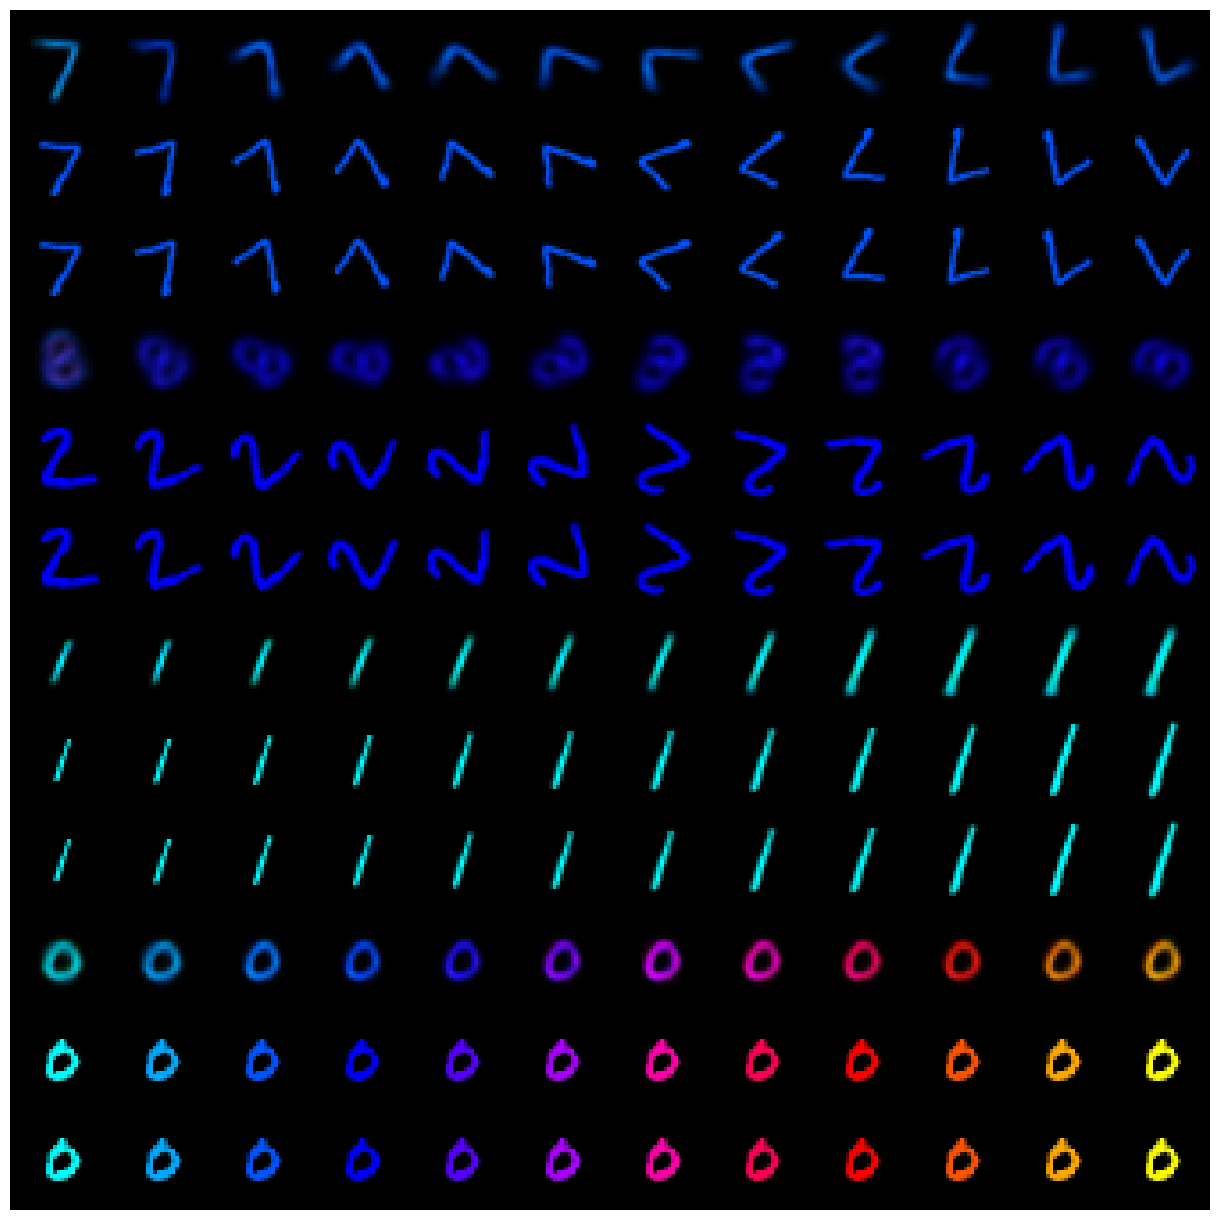

In [23]:

lim = reconstructions.shape[1]

fig, axes = plt.subplots(3*min(4, test_data.shape[0]), lim, figsize=(lim, 4*3))
for i in range(min(4, test_data.shape[0])):
    for k in range(lim):
        axes[3*i][k].imshow(np.moveaxis(reconstructions[i, k].cpu().numpy(), 0, 2), cmap='gray')
        axes[3*i][k].axis('off')
        axes[3*i+1][k].imshow(np.moveaxis(x_seen[i, k].cpu().numpy(), 0, 2), cmap='gray')
        axes[3*i+1][k].axis('off')
        axes[3*i+2][k].imshow(np.moveaxis(test_data[i, k].cpu().numpy(), 0, 2), cmap='gray')
        axes[3*i+2][k].axis('off')
        

plt.tight_layout(pad=0)

In [87]:
model#.cpu()

rec, idx = model.infer_missing(test_data[:10].cuda(), test_seq_mask[:10].cuda(), test_pix_mask[:10].cuda())
rec.shape

tensor([-36.6915, -30.7312, -59.9264, -10.2533, -20.4815, -18.8149, -28.9064,
        -21.9779, -18.8726, -73.1670], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor([[ 9,  5, 11,  0,  4, 11, 10,  6,  5,  2],
        [ 1,  9,  7,  6,  2,  4, 11,  7,  1,  5],
        [10, 11,  9,  7,  0,  2,  6,  8,  6,  3],
        [ 7,  3,  6,  9,  6,  6,  7,  4,  4, 10],
        [ 8,  4,  5, 10,  7,  7,  5,  9,  9,  7],
        [ 2,  8,  2,  1,  1,  9,  0, 11,  7,  9],
        [ 0,  7, 10,  8,  5,  0,  8,  3, 10,  8],
        [ 4, 10,  3,  5, 10,  5,  4, 10,  2, 11],
        [ 3,  1,  4, 11,  8,  3,  9,  0,  0,  6],
        [ 6,  6,  8,  3, 11, 10,  2,  2,  8,  4],
        [ 5,  0,  1,  4,  9,  8,  3,  5, 11,  1],
        [11,  2,  0,  2,  3,  1,  1,  1,  3,  0]], device='cuda:0') torch.Size([12, 10, 12, 3, 28, 28])


torch.Size([12, 10, 12, 3, 28, 28])

In [60]:
rec = torch.cat([rec[i, idx[i]] for i in range(len(idx))]).reshape(-1, 10, 12, 3, 28, 28).detach()

IndexError: index 8 is out of bounds for dimension 0 with size 8

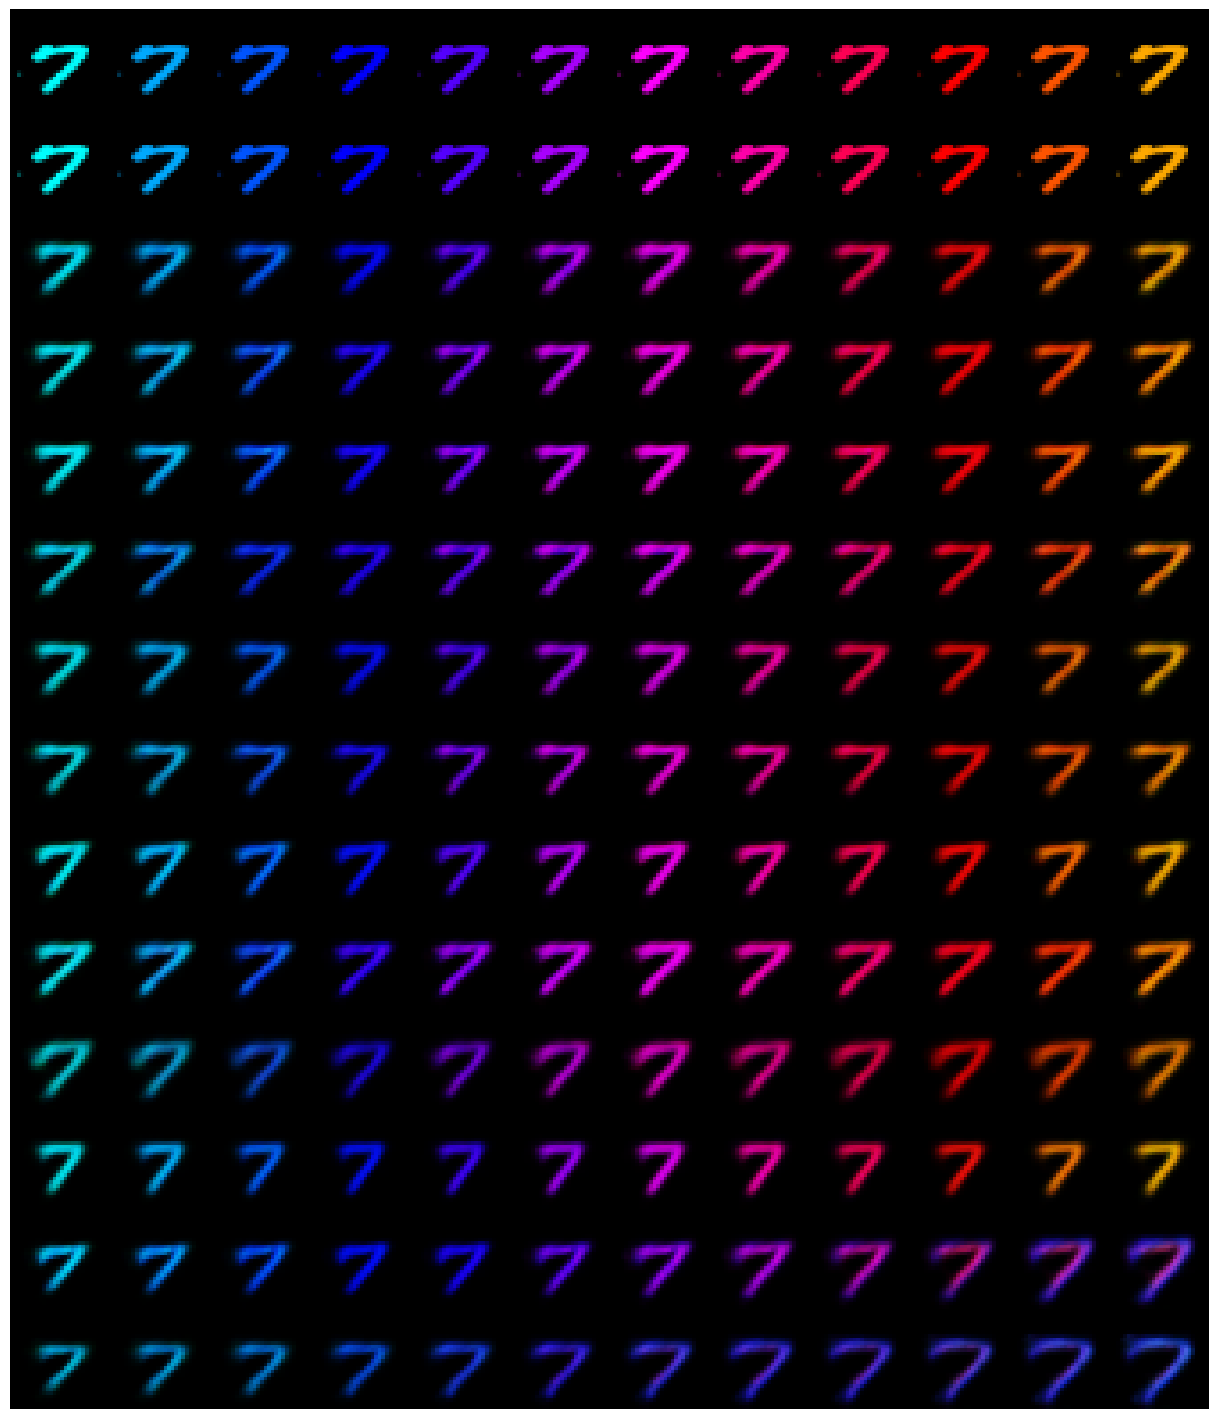

In [92]:

lim = rec.shape[2]

im_idx = 3

fig, axes = plt.subplots(rec.shape[0]+2, lim, figsize=(lim, rec.shape[0]+2))
for k in range(lim):
    axes[0][k].imshow(np.moveaxis(x_seen[im_idx, k].cpu().numpy(), 0, 2), cmap='gray')
    axes[0][k].axis('off')
    axes[1][k].imshow(np.moveaxis(test_data[im_idx, k].cpu().numpy(), 0, 2), cmap='gray')
    axes[1][k].axis('off')
for i in range(rec.shape[0]):
    for k in range(lim):
        axes[i+2][k].imshow(np.moveaxis(rec[idx[i, im_idx], im_idx, k].detach().cpu().numpy(), 0, 2), cmap='gray')
        axes[i+2][k].axis('off')
       
        

plt.tight_layout(pad=0)

In [94]:
idx[:, im_idx]

tensor([ 0,  6,  7,  9, 10,  1,  8,  5, 11,  3,  4,  2], device='cuda:0')

In [ ]:



[F.mse_loss(
            rec[idx[:, im_idx], im_idx].reshape(x.shape[0]*self.n_obs, -1),
            x.reshape(x.shape[0]*self.n_obs, -1),
            reduction="none"
        ) * pix_mask.reshape(x.shape[0]*self.n_obs, -1)
    ).sum(dim=-1).reshape(x.shape[0], -1) * seq_mask
).mean(dim=-1)

In [45]:
import torch
import numpy as np
from tqdm.auto import tqdm

prob_missing_data = 0.
prob_missing_pixels = 0.2
batch_size = 129

from utils import My_MaskedDataset, make_batched_masks

test_seq_mask = make_batched_masks(test_data, prob_missing_data, batch_size).type(torch.bool)
test_pix_mask = torch.distributions.Bernoulli(probs=1-prob_missing_pixels).sample((test_data.shape[0], test_data.shape[1],)+test_data.shape[-2:]).unsqueeze(2).repeat(1, 1, test_data.shape[2], 1, 1)
test_dataset = My_MaskedDataset(test_data, test_seq_mask, test_pix_mask)
test_loader = torch.utils.data.DataLoader(
            dataset=test_dataset,
            batch_size=batch_size,
            shuffle=False,
        )

def set_inputs_to_device(inputs):

    inputs_on_device = inputs

    if device == "cuda":
        cuda_inputs = dict.fromkeys(inputs)

        for key in inputs.keys():
            if torch.is_tensor(inputs[key]):
                cuda_inputs[key] = inputs[key].cuda()

            else:
                cuda_inputs = inputs[key]
        inputs_on_device = cuda_inputs

    return inputs_on_device

In [46]:
import torch.nn.functional as F

recon = []
recon_loss = []
x_seen = []

with torch.no_grad():
    for inputs in tqdm(test_loader):
        inputs = set_inputs_to_device(inputs)
        model_output = model(
                        inputs, epoch=np.inf, dataset_size=len(test_loader.dataset)
                    )

        recon_x = model_output.recon_x.detach()

        if model.model_config.reconstruction_loss == "mse":
            rec_loss = F.mse_loss(
                            recon_x.reshape(inputs['data'].shape[0]*model.n_obs, -1),
                            inputs['data'].reshape(inputs['data'].shape[0]*model.n_obs, -1),
                            reduction="none"
                        ).sum(dim=-1).mean(dim=-1).mean(dim=0)

        elif model.model_config.reconstruction_loss == "bce":

            rec_loss = F.binary_cross_entropy(
                            recon_x.reshape(inputs['data'].shape[0]*model.n_obs, -1),
                            inputs['data'].reshape(inputs['data'].shape[0]*model.n_obs, -1),
                            reduction="none"
                        ).sum(dim=-1).mean(dim=-1).mean(dim=0)

        recon.append(recon_x.detach())
        recon_loss.append(rec_loss.item())
        x_seen.append(model_output.x.detach())

  0%|          | 0/21 [00:00<?, ?it/s]

In [49]:
print(np.mean(recon_loss))
x_seen = torch.cat(x_seen)

41.788419995989116


TypeError: cat(): argument 'tensors' (position 1) must be tuple of Tensors, not Tensor

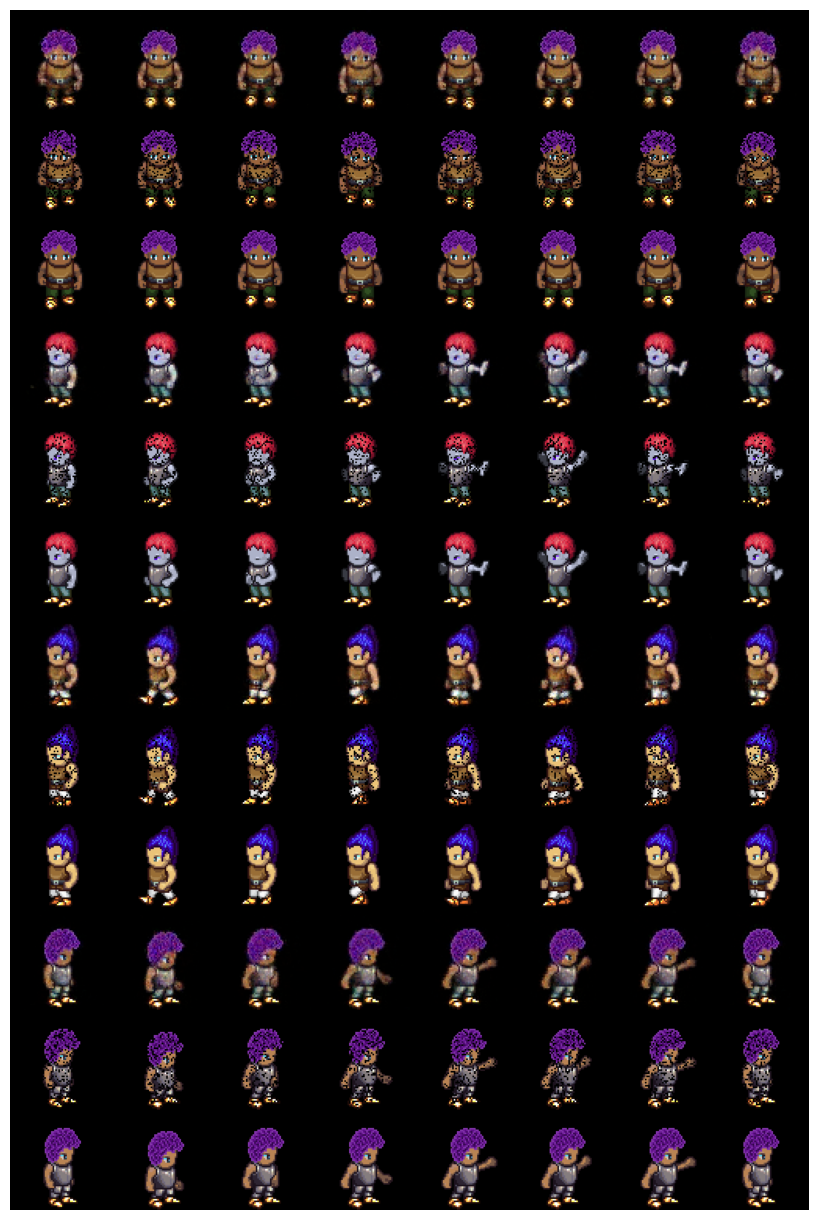

In [48]:
reconstructions = torch.clamp(torch.cat(recon), 0, 1)

lim = reconstructions.shape[1]

fig, axes = plt.subplots(3*min(4, test_data.shape[0]), lim, figsize=(lim, 4*3))
for i in range(min(4, test_data.shape[0])):
    for k in range(lim):
        axes[3*i][k].imshow(np.moveaxis(reconstructions[i, k].cpu().numpy(), 0, 2), cmap='gray')
        axes[3*i][k].axis('off')
        axes[3*i+1][k].imshow(np.moveaxis(x_seen[i, k].cpu().numpy(), 0, 2), cmap='gray')
        axes[3*i+1][k].axis('off')
        axes[3*i+2][k].imshow(np.moveaxis(test_data[i, k].cpu().numpy(), 0, 2), cmap='gray')
        axes[3*i+2][k].axis('off')
        

plt.tight_layout(pad=0)

standard prior


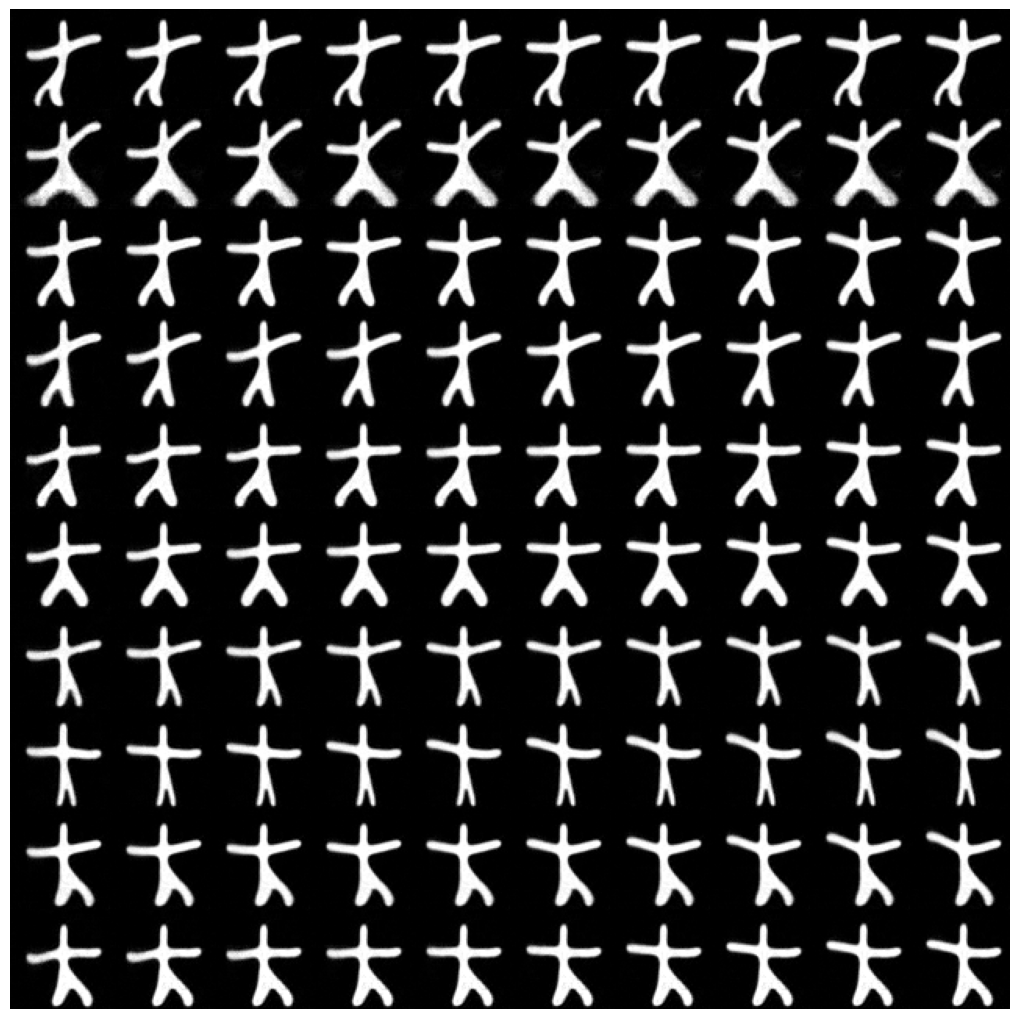

In [26]:
torch.manual_seed(2)

if model.prior == "standard":
    print("standard prior")
    z = torch.randn(10, model.latent_dim).cuda()
elif model.prior == "vamp":
    print("vamp prior")
    means = model.pseudo_inputs(model.idle_input.to(device))[
                :10
            ].reshape((10,) + model.model_config.input_dim)

    encoder_output = model.encoder(means)
    mu, log_var = (
        encoder_output.embedding,
        encoder_output.log_covariance,
    )
    std = torch.exp(0.5 * log_var)
    eps = torch.randn_like(std)
    z = mu + eps * std

#z = torch.randn(10, model.latent_dim).cuda()

#z = z[1].unsqueeze(0).repeat(10, 1)
#z.shape
gen = torch.clamp(model.generate(z), 0, 1).detach().cpu()

lim = model.n_obs
im_size = 28

torch.manual_seed(888)
#idx = torch.randperm(len(train_data))

# Train recon
fig, axes = plt.subplots(10, lim, figsize=(lim, 10))
for i in range(10):
    for k in range(lim):
        axes[i][k].imshow(np.moveaxis(gen[i, k].cpu().numpy(), 0, 2), cmap='gray')
        axes[i][k].axis('off')
plt.tight_layout(pad=0)
#plt.savefig('plots/vamp/first_lvae_iaf_test_generation.png', bbox_inches='tight')

In [28]:
import imageio

#for 
for i in range(model.n_obs):
    if gen.shape[2] == 1:
        gen = gen.repeat(1, 1, 3, 1, 1)
    plt.imsave(f'plots/to_gif/case_1/{i}.png', np.moveaxis(gen[-4, i].cpu().numpy(), 0, 2))
import imageio
images = []
for filename in sorted(os.listdir('plots/to_gif/case_1')):
    if '.png' in filename:
        images.append(imageio.imread(os.path.join('plots/to_gif/case_1', filename)))
imageio.mimsave('plots/to_gif/case_1/movie_ter.gif', images)

/tmp/ipykernel_9214/1724551207.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(os.path.join('plots/to_gif/case_1', filename)))


In [34]:
train_data = torch.load(os.path.join('/gpfswork/rech/wlr/uhw48em/rvae/data/sprites/Sprites_train.pt'), map_location=device)['data']#[:5000]


In [35]:
gen[0].shape

torch.Size([8, 3, 64, 64])

In [36]:
(gen[0].unsqueeze(0).cuda() - train_data).shape

torch.Size([9000, 8, 3, 64, 64])

In [58]:
idx = -4

closest = torch.argmin(torch.norm(gen[idx].unsqueeze(0).cuda().reshape(1, -1) - train_data.reshape(-1, 8*3*64*64), dim=-1))

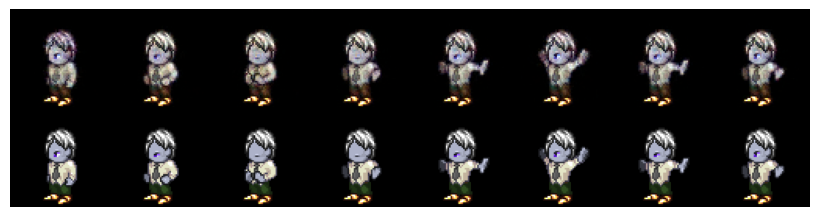

In [59]:
# Train recon
fig, axes = plt.subplots(2, lim, figsize=(lim, 2))

for k in range(lim):
    axes[0][k].imshow(np.moveaxis(gen[idx, k].cpu().numpy(), 0, 2), cmap='gray')
    axes[0][k].axis('off')
    axes[1][k].imshow(np.moveaxis(train_data[closest, k].cpu().numpy(), 0, 2), cmap='gray')
    axes[1][k].axis('off')
plt.tight_layout(pad=0)

In [29]:
torch.manual_seed(888)

if model.prior == "standard":
    print("standard prior")
    z = torch.randn(10, model.latent_dim).cuda()
elif model.prior == "vamp":
    print("vamp prior")
    means = model.pseudo_inputs(model.idle_input.to(device))[
                :10
            ].reshape((10,) + model.model_config.input_dim)

    encoder_output = model.encoder(means)
    mu, log_var = (
        encoder_output.embedding,
        encoder_output.log_covariance,
    )
    std = torch.exp(0.5 * log_var)
    eps = torch.randn_like(std)
    z = mu + eps * std

#z = torch.randn(10, model.latent_dim).cuda()

#z = z[1].unsqueeze(0).repeat(10, 1)
#z.shape
gen = torch.clamp(model.generate(z), 0, 1).detach().cpu()

lim = model.n_obs
im_size = 28

torch.manual_seed(888)
#idx = torch.randperm(len(train_data))

# Train recon
fig, axes = plt.subplots(10, lim, figsize=(lim, 10))
for i in range(10):
    for k in range(lim):
        axes[i][k].imshow(np.moveaxis(gen[i, k].cpu().numpy(), 0, 2), cmap='gray')
        axes[i][k].axis('off')
plt.tight_layout(pad=0)
#plt.savefig('plots/vamp/first_lvae_iaf_test_generation.png', bbox_inches='tight')dd

tensor([[[[0.0000e+00, 4.0399e-04, 0.0000e+00,  ..., 2.0851e-03,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 4.4178e-05,  ..., 8.1975e-05,
           1.0075e-03, 7.1127e-04],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [1.7642e-03, 1.9935e-04, 9.5009e-04,  ..., 0.0000e+00,
           8.9348e-04, 0.0000e+00],
          [0.0000e+00, 4.8355e-04, 0.0000e+00,  ..., 9.2553e-04,
           1.0129e-03, 1.1365e-03],
          [8.5363e-06, 0.0000e+00, 8.0617e-05,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[0.0000e+00, 2.1046e-04, 0.0000e+00,  ..., 2.0947e-03,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 9.1963e-04,  ..., 2.5593e-04,
           4.9090e-04, 4.7314e-04],
          [0.0000e+00, 3.3581e-04, 1.0433e-03,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [2.0030e-03, 6.3055e-04, 1.6777e-03,  ..., 0.0000

In [8]:
train_data.reshape(-1)

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')

In [10]:
a = torch.zeros((train_data.shape[:2]))
a[:, :2] = 1
a.sum(dim=-1)

tensor([2., 2., 2.,  ..., 2., 2., 2.])

In [26]:
(0.78 - 2 / 12) * 12 / 10

0.7360000000000001

In [28]:
bern = torch.distributions.Bernoulli(probs=0.736).sample((train_data.shape[0], train_data.shape[1]-2))
a[:, 2:] = bern

In [11]:
def shuffle_along_axis(a, axis):
    idx = np.random.rand(*a.shape).argsort(axis=axis)
    return np.take_along_axis(a,idx,axis=axis)

a_shuf = shuffle_along_axis(a, axis=-1)

NameError: name 'a' is not defined

In [30]:
a_shuf.sum()/ (48000*12)

tensor(0.7800)

In [30]:
probs = np.array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]).astype(np.float)
probs /= probs.sum()
probs = torch.tensor(probs)

np.random.choice(np.arange(train_data.shape[1]), p=probs)

/tmp/ipykernel_10962/4156233049.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  probs = np.array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]).astype(np.float)


11

In [15]:
np.arange(train_data.shape[1]).shape

(12,)

In [12]:
(a_shuf.sum(dim=-1)<2).sum()

tensor(0)

In [21]:
torch.save(mask, '../../data/color')

tensor(0.4998)

In [25]:
from utils import My_MaskedDataset, make_batched_masks

train_mask = make_batched_masks(train_data, prob_missing_data=0, batch_size=128)
eval_mask = make_batched_masks(eval_data, prob_missing_data=0, batch_size=128)

In [26]:
from pythae.models.nn import BaseEncoder, BaseDecoder
from pythae.models.base.base_utils import ModelOutput
import torch.nn as nn


### Define paper encoder network
class VAEEncoder(BaseEncoder):
    def __init__(self, args: dict):
        BaseEncoder.__init__(self)
        self.input_dim = args.input_dim
        self.latent_dim = args.latent_dim


        self.fc1 = nn.Linear(np.prod(args.input_dim), 200)
        self.fc2 = nn.Linear(200, 200)

        self.embedding = nn.Linear(200, self.latent_dim)
        self.log_var = nn.Linear(200, self.latent_dim)
        #self.context = nn.Linear(200, self.context_dim)

    def forward(self, x):
        output = ModelOutput()

        out = torch.relu(self.fc1(x))
        out = torch.relu(self.fc2(out))

        output["embedding"] = self.embedding(out)
        output["log_covariance"] = self.log_var(out)
        #output["context"] = self.context(out)

        return output

### Define paper decoder network
class VAEDecoder(BaseDecoder):
    def __init__(self, args: dict):
        BaseDecoder.__init__(self)

        self.input_dim = args.input_dim
        self.latent_dim = args.latent_dim

        self.fc1 = nn.Linear(self.latent_dim, 200)
        self.fc2 = nn.Linear(200, 200)
        self.fc3 = nn.Linear(200, np.prod(args.input_dim))


    def forward(self, z: torch.Tensor):

        output = ModelOutput()

        out = torch.relu(self.fc1(z))
        out = torch.relu(self.fc2(out))
        out = torch.sigmoid(self.fc3(out))

        output["reconstruction"] = out.reshape((z.shape[0],) + self.input_dim)

        return output



### Define paper encoder network
class TimeEncoder(BaseEncoder):
    def __init__(self, args: dict):
        BaseEncoder.__init__(self)
        self.input_dim = args.input_dim
        self.latent_dim = args.latent_dim
        self.context_dim = args.context_dim


        self.fc1 = nn.Linear(np.prod(args.input_dim), 500)
        self.fc2 = nn.Linear(500, 200)

        self.time_fc1 = nn.Linear(1, 50)
        self.time_fc2 = nn.Linear(50, 50)

        self.embedding = nn.Linear(250, self.latent_dim)
        self.log_var = nn.Linear(250, self.latent_dim)
        #self.context = nn.Linear(250, self.context_dim)

    def forward(self, x, t=None):
        output = ModelOutput()

        out = torch.relu(self.fc1(x.reshape(-1, np.prod(self.input_dim))))
        out = torch.relu(self.fc2(out))

        time_out = torch.relu(self.time_fc1(t))
        time_out = torch.relu(self.time_fc2(time_out))
        out = torch.cat((out, time_out), dim=-1)

        output["embedding"] = self.embedding(out)
        output["log_covariance"] = self.log_var(out)
        #output["context"] = self.context(out)

        return output

### Define paper decoder network
class TimeDecoder(BaseDecoder):
    def __init__(self, args: dict):
        BaseDecoder.__init__(self)

        self.input_dim = args.input_dim
        self.latent_dim = args.latent_dim

        self.fc1 = nn.Linear(self.latent_dim, 500)
        self.fc2 = nn.Linear(500, 200)

        self.time_fc1 = nn.Linear(1, 50)
        self.time_fc2 = nn.Linear(50, 50)

        self.fc3 = nn.Linear(250, np.prod(args.input_dim))


    def forward(self, z: torch.Tensor, t=None):

        output = ModelOutput()

        out = torch.relu(self.fc1(z))
        out = torch.relu(self.fc2(out))

        time_out = torch.relu(self.time_fc1(t))
        time_out = torch.relu(self.time_fc2(time_out))
        out = torch.cat((out, time_out), dim=-1)

        out = torch.sigmoid(self.fc3(out))

        output["reconstruction"] = out.reshape((z.shape[0],) + self.input_dim)

        return output


### Define paper encoder network
class Encoder(BaseEncoder):
    def __init__(self, args: dict):
        BaseEncoder.__init__(self)
        self.input_dim = args.input_dim
        self.latent_dim = args.latent_dim
        self.context_dim = args.context_dim

        self.fc = nn.Sequential(
            nn.Linear(np.prod(args.input_dim), 1024),
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.ReLU(),
        )

        self.embedding = nn.Linear(256, self.latent_dim)
        self.log_var = nn.Linear(256, self.latent_dim)
        self.context = nn.Linear(256, self.context_dim)

    def forward(self, x):
        output = ModelOutput()

        out = self.fc(x.reshape(-1, np.prod(self.input_dim)))

        output["embedding"] = self.embedding(out)
        output["log_covariance"] = self.log_var(out)
        output["context"] = self.context(out)

        return output

### Define paper decoder network
class Decoder(BaseDecoder):
    def __init__(self, args: dict):
        BaseDecoder.__init__(self)

        self.input_dim = args.input_dim
        self.latent_dim = args.latent_dim

        self.fc = nn.Sequential(
            nn.Linear(self.latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 1024),
            nn.ReLU(),
            nn.Linear(1024, np.prod(self.input_dim)),
            nn.Sigmoid(),
        )


    def forward(self, z: torch.Tensor):

        output = ModelOutput()

        out = self.fc(z)

        output["reconstruction"] = out.reshape((z.shape[0],) + self.input_dim)

        return output



## VAE

## CVAE

In [ ]:
from pythae.models import LCVAE, LCVAE_Config
from pythae.trainers import BaseTrainerConfig, BaseTrainer
import torch.optim as optim


config = LCVAE_Config(
    input_dim=(1, 28, 28),
    latent_dim=2,
    n_obs_per_ind=8
)

encoder = TimeEncoder(config)
decoder = TimeDecoder(config)

vae = LCVAE(config, encoder, decoder).cuda()


#train_dataset = DynBinarizedMNIST(train_data.reshape(-1, 8, 784))
#eval_dataset = DynBinarizedMNIST(eval_data.reshape(-1, 8, 784))

training_config = BaseTrainerConfig(
    num_epochs=1000,
    learning_rate=1e-3,
    batch_size=100
)

### Optimizer
vae_optimizer = torch.optim.Adam(vae.parameters(), lr=training_config.learning_rate, eps=1e-4)

### Scheduler
vae_scheduler = torch.optim.lr_scheduler.MultiStepLR(
    vae_optimizer, milestones=[10000], gamma=10**(-1/7), verbose=True
)

vae_trainer = BaseTrainer(
        model=vae,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        training_config=training_config,
        optimizer=vae_optimizer,
        scheduler=vae_scheduler,
        callbacks=None,
    )

In [ ]:
_ = vae({'data': train_data[:5].cuda().reshape((-1, 8, 28*28)).float()}, epoch=0)

In [ ]:
vae_trainer.train()

In [ ]:
model_rec = vae_trainer._best_model

In [ ]:
z = torch.rand(10, 2).cuda()
gen = model_rec.generate(z).reshape(z.shape[0], 8, -1)
gen.shape

In [ ]:
lim = 8
im_size = 28

torch.manual_seed(8)
idx = torch.randperm(len(gen))

# Train recon
fig, axes = plt.subplots(4, lim, figsize=(lim, 4))
torch.manual_seed(88)
for k in range(lim):
    i, t = 0, k
    axes[0][k].imshow(gen[i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[0][k].axis('off')
    i, t = 1, k
    axes[1][k].imshow(gen[i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[1][k].axis('off')
    i, t = 2, k
    axes[2][k].imshow(gen[i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[2][k].axis('off')
    i, t = 3, k
    axes[3][k].imshow(gen[i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[3][k].axis('off')

In [ ]:
inp = iter(vae_trainer.eval_loader).next()

emb = model_rec(inp).z.detach().cpu()
recon = model_rec(inp).recon_x.detach().cpu()

In [ ]:
plt.scatter(emb[:8, 0], emb[:8, 1])

In [ ]:
lim = 8
im_size = 28

torch.manual_seed(8)
idx = torch.randperm(len(recon))

# Train recon
fig, axes = plt.subplots(4, lim, figsize=(lim, 4))
torch.manual_seed(88)
for k in range(lim):
    i, t = 0, k
    axes[0][k].imshow(recon[i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[0][k].axis('off')
    i, t = 1, k
    axes[1][k].imshow(recon[i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[1][k].axis('off')
    i, t = 2, k
    axes[2][k].imshow(recon[i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[2][k].axis('off')
    i, t = 3, k
    axes[3][k].imshow(recon[i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[3][k].axis('off')

In [ ]:
from pythae.models import VAE, VAEConfig
from pythae.trainers import BaseTrainerConfig, BaseTrainer
import torch.optim as optim


config = VAEConfig(
    input_dim=(1, 28, 28),
    latent_dim=64
)

encoder = VAEEncoder(config)
decoder = VAEDecoder(config)

vae = VAE(config, encoder, decoder).cuda()


train_dataset = DynBinarizedMNIST(train_data.reshape(-1, 784))
eval_dataset = DynBinarizedMNIST(eval_data.reshape(-1, 784))

training_config = BaseTrainerConfig(
    num_epochs=10,
    learning_rate=1e-3,
    batch_size=100
)

### Optimizer
vae_optimizer = torch.optim.Adam(vae.parameters(), lr=training_config.learning_rate, eps=1e-4)

### Scheduler
vae_scheduler = torch.optim.lr_scheduler.MultiStepLR(
    vae_optimizer, milestones=[10000], gamma=10**(-1/7), verbose=True
)

vae_trainer = BaseTrainer(
        model=vae,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        training_config=training_config,
        optimizer=vae_optimizer,
        scheduler=vae_scheduler,
        callbacks=None,
    )

In [ ]:
vae_trainer.train()

In [ ]:
model_rec = vae#trainer._best_model

In [ ]:
z = torch.rand(10, 64).cuda()
gen = model_rec.decoder(z).reconstruction.detach().cpu()
gen.shape

In [ ]:
lim = 8
im_size = 28

torch.manual_seed(8)
idx = torch.randperm(len(gen))

# Train recon
fig, axes = plt.subplots(4, lim, figsize=(lim, 4))
torch.manual_seed(88)
for k in range(lim):
    i, t = 0, k
    axes[0][k].imshow(gen[i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[0][k].axis('off')
    i, t = 1, k
    axes[1][k].imshow(gen[i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[1][k].axis('off')
    i, t = 2, k
    axes[2][k].imshow(gen[i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[2][k].axis('off')
    i, t = 3, k
    axes[3][k].imshow(gen[i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[3][k].axis('off')

In [ ]:
inp = iter(vae_trainer.eval_loader).next()

emb = model_rec(inp).z.detach().cpu()

In [ ]:
plt.scatter(emb[:8, 0], emb[:8, 1])

In [ ]:
lim = 8
im_size = 28

torch.manual_seed(8)
idx = torch.randperm(len(recon))

# Train recon
fig, axes = plt.subplots(4, lim, figsize=(lim, 4))
torch.manual_seed(88)
for k in range(lim):
    i, t = 0, k
    axes[0][k].imshow(recon[i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[0][k].axis('off')
    i, t = 1, k
    axes[1][k].imshow(recon[i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[1][k].axis('off')
    i, t = 2, k
    axes[2][k].imshow(recon[i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[2][k].axis('off')
    i, t = 3, k
    axes[3][k].imshow(recon[i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[3][k].axis('off')

## LVAE

In [73]:
from pythae.models import LVAE_IAF, LVAE_IAF_Config

config = LVAE_IAF_Config(
    input_dim=(3, 64, 64),
    n_obs_per_ind=train_data.shape[1],
    latent_dim=16,
    n_hidden_in_made=3,
    n_made_blocks=2,
    warmup=10,
    context_dim=32,
    prior="vamp",
    posterior="gaussian",
    vamp_number_components=500,
    linear_scheduling_steps=0
)

encoder = Encoder(config)
decoder = Decoder(config)

model = LVAE_IAF(config, encoder, decoder).cuda()
model

LVAE_IAF(
  (decoder): Decoder(
    (fc): Sequential(
      (0): Linear(in_features=16, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=1024, bias=True)
      (3): ReLU()
      (4): Linear(in_features=1024, out_features=12288, bias=True)
      (5): Sigmoid()
    )
  )
  (encoder): Encoder(
    (fc): Sequential(
      (0): Linear(in_features=12288, out_features=1024, bias=True)
      (1): ReLU()
      (2): Linear(in_features=1024, out_features=256, bias=True)
      (3): ReLU()
    )
    (embedding): Linear(in_features=256, out_features=16, bias=True)
    (log_var): Linear(in_features=256, out_features=16, bias=True)
    (context): Linear(in_features=256, out_features=32, bias=True)
  )
  (flows): ModuleList(
    (0): IAF(
      (net): ModuleList(
        (0): MADE(
          (context_input_layer): MaskedLinear(
            in_features=16, out_features=128, bias=True
            (context_linear): Linear(in_features=32, out_features=128, bias

In [74]:
train_data[:5].shape

torch.Size([5, 8, 3, 64, 64])

In [75]:
_ = model({'data': train_data[:5].cuda().float(), 'mask':train_mask[:5].cuda()}, epoch=100000)

In [76]:
from pythae.trainers import BaseTrainerConfig, BaseTrainer
import torch.optim as optim

training_config = BaseTrainerConfig(
    num_epochs=100,
    learning_rate=1e-3,
    batch_size=128
)

### Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=training_config.learning_rate, eps=1e-4)

### Scheduler
scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer, milestones=[100], gamma=10**(-1/7), verbose=True
)

train_dataset = My_MaskedDataset(train_data, train_mask)
eval_dataset = My_MaskedDataset(eval_data, eval_mask)

trainer = BaseTrainer(
        model=model,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        training_config=training_config,
        optimizer=optimizer,
        scheduler=scheduler,
        callbacks=None,
    )

Adjusting learning rate of group 0 to 1.0000e-03.


In [77]:
next(iter(trainer.train_loader))[0]

tensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],


         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  

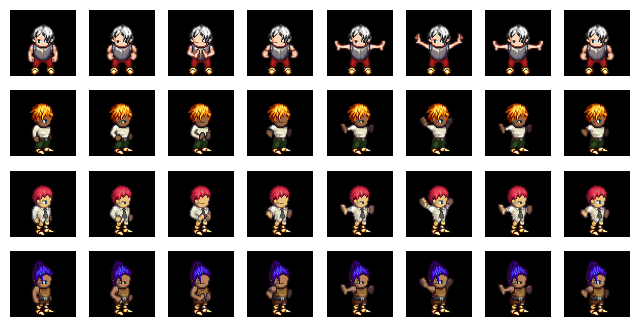

In [78]:
inp = iter(trainer.train_loader).next()[0]

lim = model.n_obs
im_size = 28

torch.manual_seed(8)
idx = torch.randperm(len(inp))

# Train recon
fig, axes = plt.subplots(4, lim, figsize=(lim, 4))
torch.manual_seed(88)
for k in range(lim):
    i, t = 0, k
    axes[0][k].imshow(np.moveaxis(inp[idx][i, t].squeeze(0).squeeze(0).cpu().numpy(), 0, 2), cmap='gray')
    axes[0][k].axis('off')
    i, t = 1, k
    axes[1][k].imshow(np.moveaxis(inp[idx][i, t].squeeze(0).squeeze(0).cpu().numpy(), 0, 2), cmap='gray')
    axes[1][k].axis('off')
    i, t = 2, k
    axes[2][k].imshow(np.moveaxis(inp[idx][i, t].squeeze(0).squeeze(0).cpu().numpy(), 0, 2), cmap='gray')
    axes[2][k].axis('off')
    i, t = 3, k
    axes[3][k].imshow(np.moveaxis(inp[idx][i, t].squeeze(0).squeeze(0).cpu().numpy(), 0, 2), cmap='gray')
    axes[3][k].axis('off')

In [79]:
#model.warmup = 0
trainer.train()

Model passed sanity check !

Created dummy_output_dir/VAE_IAF_training_2022-11-07_14-41-18. 
Training config, checkpoints and final model will be saved here.

Successfully launched training !



Training of epoch 1/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 1/100:   0%|          | 0/8 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 424.3356
Eval loss: 267.094
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Training of epoch 2/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 2/100:   0%|          | 0/8 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 254.7963
Eval loss: 240.8084
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Training of epoch 3/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 3/100:   0%|          | 0/8 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 226.6745
Eval loss: 201.6785
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Training of epoch 4/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 4/100:   0%|          | 0/8 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 179.8297
Eval loss: 165.0263
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Training of epoch 5/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 5/100:   0%|          | 0/8 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 156.9743
Eval loss: 148.8352
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Training of epoch 6/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 6/100:   0%|          | 0/8 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 138.2133
Eval loss: 128.0539
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Training of epoch 7/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 7/100:   0%|          | 0/8 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 118.0068
Eval loss: 111.1244
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Training of epoch 8/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 8/100:   0%|          | 0/8 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 102.8133
Eval loss: 97.1047
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Training of epoch 9/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 9/100:   0%|          | 0/8 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 91.8553
Eval loss: 88.3946
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Training of epoch 10/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 10/100:   0%|          | 0/8 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 158.3726
Eval loss: 157.4405
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Training of epoch 11/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 11/100:   0%|          | 0/8 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 136.515
Eval loss: 123.0216
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Training of epoch 12/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 12/100:   0%|          | 0/8 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 116.1169
Eval loss: 106.8507
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Training of epoch 13/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 13/100:   0%|          | 0/8 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 106.2108
Eval loss: 111.2499
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Training of epoch 14/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 14/100:   0%|          | 0/8 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 98.6453
Eval loss: 98.4405
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Training of epoch 15/100:   0%|          | 0/63 [00:00<?, ?batch/s]

Eval of epoch 15/100:   0%|          | 0/8 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 94.1227
Eval loss: 97.8383
--------------------------------------------------------------------------


Adjusting learning rate of group 0 to 1.0000e-03.


Training of epoch 16/100:   0%|          | 0/63 [00:00<?, ?batch/s]

KeyboardInterrupt: 

In [27]:
from pythae.models import LVAE_IAF
model_rec = LVAE_IAF.load_from_folder('dummy_output_dir/VAE_IAF_training_2022-11-09_10-43-26/final_model').cuda()
#model.model_config.reconstruction_loss = 'bce'
#model_rec = trainer._best_model

In [28]:
lim = 2
gran = 10
X = torch.linspace(lim, -lim, gran).type(torch.float)
Y = torch.linspace(-lim, lim, gran).type(torch.float)
mesh = torch.tensor([[y, x] for x in X for y in Y]).to(device)

0


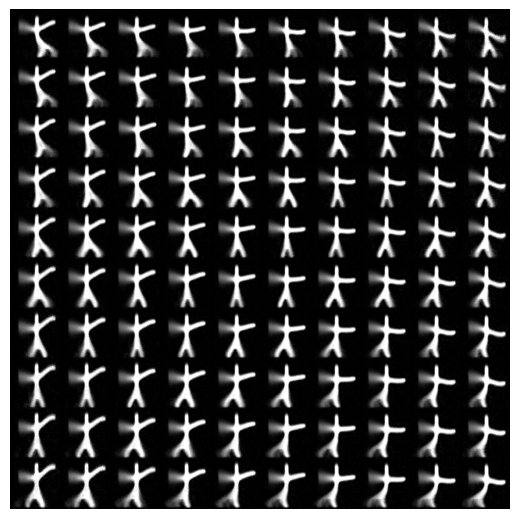

1


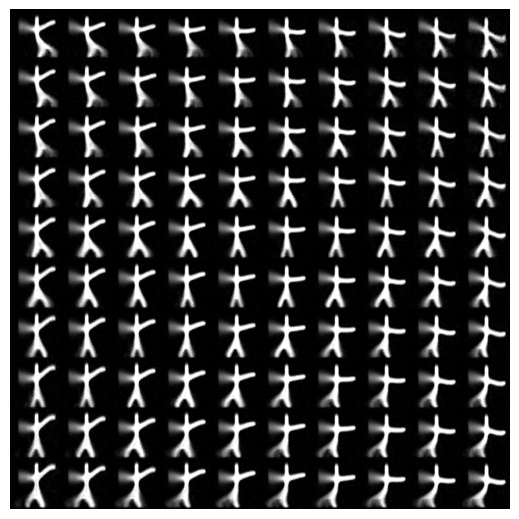

KeyboardInterrupt: 

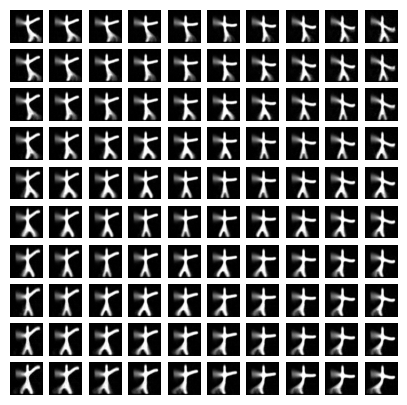

In [19]:
z_fin = mesh
for j in range(model_rec.n_obs):
    if j > 0:
        flow_output = model_rec.flows[j-1].inverse(z_fin)
        z_fin = flow_output.out

    rec = torch.clamp(model_rec.decoder(z_fin).reconstruction.reshape(gran, gran, 1, 64, 64), 0, 1).detach().cpu().numpy()

    # latent space
    fig, axes = plt.subplots(gran, gran, figsize=(5, 5))
    torch.manual_seed(88)
    for i in range(gran):
        for k in range(gran):
            axes[i][k].imshow(np.moveaxis(rec[i, k], 0, 2), cmap='gray')
            axes[i][k].axis('off')
    fig.tight_layout(pad=0)
    print(f"{j}")
    plt.show()

In [71]:
#inp = iter(trainer.eval_loader).next()
#model_rec.get_nll(inp.data.reshape(-1, 3, 28, 28))

-254.6768033603827

In [13]:
torch.__version__
model.prior

'standard'

In [31]:
torch.manual_seed(888)

if model_rec.prior == "standard":
    print("standard prior")
    z = torch.randn(10, model_rec.latent_dim).cuda()
elif model_rec.prior == "vamp":
    print("vamp prior")
    means = model_rec.pseudo_inputs(model_rec.idle_input.to(device))[
                :10
            ].reshape((10,) + model_rec.model_config.input_dim)

    encoder_output = model.encoder(means)
    mu, log_var = (
        encoder_output.embedding,
        encoder_output.log_covariance,
    )
    std = torch.exp(0.5 * log_var)
    eps = torch.randn_like(std)
    z = mu + eps * std

#z = torch.randn(10, model_rec.latent_dim).cuda()


standard prior


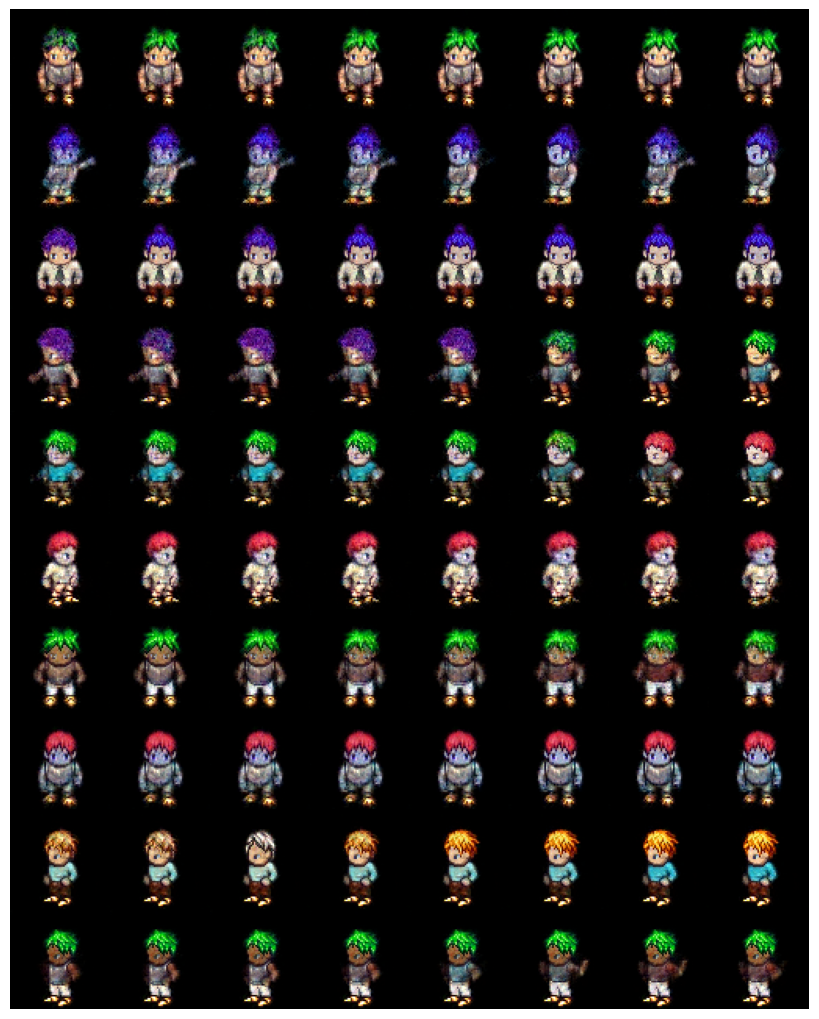

In [30]:
#z = z[1].unsqueeze(0).repeat(10, 1)
#z.shape
gen = torch.clamp(model_rec.generate(z), 0, 1).detach().cpu()

lim = model_rec.n_obs
im_size = 28

torch.manual_seed(888)
#idx = torch.randperm(len(train_data))

# Train recon
fig, axes = plt.subplots(10, lim, figsize=(lim, 10))
for i in range(10):
    for k in range(lim):
        axes[i][k].imshow(np.moveaxis(gen[i, k].cpu().numpy(), 0, 2), cmap='gray')
        axes[i][k].axis('off')
plt.tight_layout(pad=0)
#plt.savefig('plots/vamp/first_lvae_iaf_test_generation.png', bbox_inches='tight')

In [43]:
train_data.shape

torch.Size([700, 10, 1, 64, 64])

In [45]:
import imageio

for i in range(model_rec.n_obs):
    plt.imsave(f'plots/to_gif/case_1/{i}.png', np.moveaxis(train_data[0, i].cpu().numpy(), 0, 2))

In [46]:
os.listdir('plots/to_gif/case_1')

['5.png',
 '3.png',
 '7.png',
 '0.png',
 '2.png',
 '4.png',
 '6.png',
 '1.png',
 'movie.gif']

In [48]:
import imageio
images = []
for filename in sorted(os.listdir('plots/to_gif/case_1')):
    images.append(imageio.imread(os.path.join('plots/to_gif/case_1', filename)))
imageio.mimsave('plots/to_gif/case_1/movie.gif', images)

/tmp/ipykernel_30948/755526184.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(os.path.join('plots/to_gif/case_1', filename)))


In [53]:
gen = model_rec.generate(z).detach().cpu()
gen.shape

torch.Size([10, 8, 3, 64, 64])

In [54]:
gen.shape

torch.Size([10, 8, 3, 64, 64])

TypeError: 'AxesSubplot' object is not subscriptable

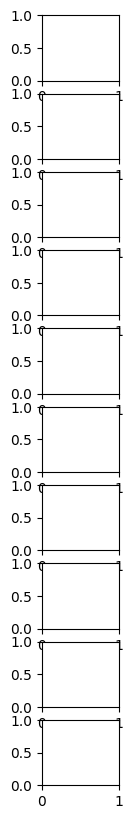

In [20]:
lim = model_rec.n_obs
im_size = 28

torch.manual_seed(888)
#idx = torch.randperm(len(train_data))

# Train recon
fig, axes = plt.subplots(10, lim, figsize=(lim, 10))
for i in range(10):
    for k in range(lim):
        axes[i][k].imshow(np.moveaxis(gen[i, k].cpu().numpy(), 0, 2), cmap='gray')
        axes[i][k].axis('off')
plt.tight_layout(pad=0)
#plt.savefig('plots/vamp/first_lvae_iaf_test_generation.png', bbox_inches='tight')

In [16]:
inp = iter(trainer.eval_loader).next()

inp.data = inp.data[12].unsqueeze(0).repeat(10, 1, 1, 1, 1)

output = model_rec(inp, epoch=100000)
recon = output.recon_x.detach()
z_seq = output.z_seq.detach()


NameError: name 'trainer' is not defined

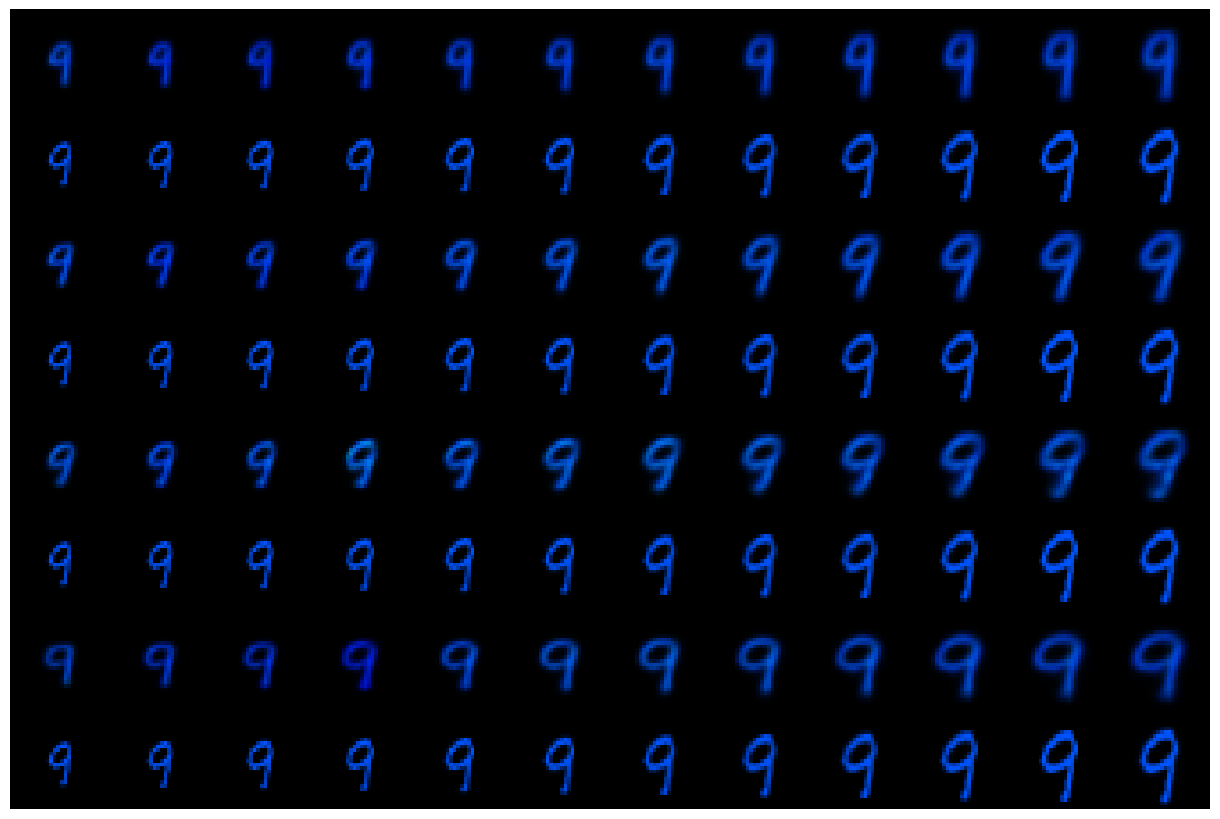

In [36]:
lim = model_rec.n_obs
im_size = 28

torch.manual_seed(8)
idx = torch.randperm(len(recon))

# Train recon
fig, axes = plt.subplots(2*4, lim, figsize=(lim, 4*2))
torch.manual_seed(88)
for k in range(lim):
    i, t = 0, k
    axes[0][k].imshow(np.moveaxis(recon[i, t].cpu().numpy(), 0, 2), cmap='gray')
    axes[0][k].axis('off')
    axes[1][k].imshow(np.moveaxis(inp.data[i, t].cpu().numpy(), 0, 2), cmap='gray')
    axes[1][k].axis('off')
    i, t = 1, k
    axes[2][k].imshow(np.moveaxis(recon[i, t].cpu().numpy(), 0, 2), cmap='gray')
    axes[2][k].axis('off')
    axes[3][k].imshow(np.moveaxis(inp.data[i, t].cpu().numpy(), 0, 2), cmap='gray')
    axes[3][k].axis('off')
    i, t = 2, k
    axes[4][k].imshow(np.moveaxis(recon[i, t].cpu().numpy(), 0, 2), cmap='gray')
    axes[4][k].axis('off')
    axes[5][k].imshow(np.moveaxis(inp.data[i, t].cpu().numpy(), 0, 2), cmap='gray')
    axes[5][k].axis('off')
    i, t = 3, k
    axes[6][k].imshow(np.moveaxis(recon[i, t].cpu().numpy(), 0, 2), cmap='gray')
    axes[6][k].axis('off')
    axes[7][k].imshow(np.moveaxis(inp.data[i, t].cpu().numpy(), 0, 2), cmap='gray')
    axes[7][k].axis('off')
plt.tight_layout(pad=0)
#plt.savefig('plots/vamp/possible_evolutions_from_0.png', bbox_inches='tight')

RuntimeError: shape '[28, 28]' is invalid for input of size 2352

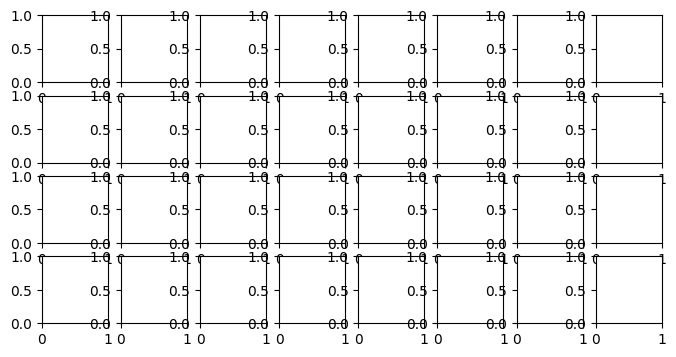

In [31]:
lim = 8
im_size = 28

torch.manual_seed(8)
idx = torch.randperm(len(recon))

# Train recon
fig, axes = plt.subplots(4, lim, figsize=(lim, 4))
torch.manual_seed(88)
for k in range(lim):
    i, t = 0, k
    axes[0][k].imshow(recon[i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[0][k].axis('off')
    i, t = 1, k
    axes[1][k].imshow(recon[i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[1][k].axis('off')
    i, t = 2, k
    axes[2][k].imshow(recon[i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[2][k].axis('off')
    i, t = 3, k
    axes[3][k].imshow(recon[i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[3][k].axis('off')

In [1]:
inp.data.shape

NameError: name 'inp' is not defined

In [24]:
a = torch.tensor([[1], [2], [3]])
a.repeat(1, 2).reshape(-1, 1)

tensor([[1],
        [1],
        [2],
        [2],
        [3],
        [3]])

In [10]:
#inp = iter(trainer.eval_loader).next()

inp = train_data

n_samples = 20

output = model_rec({'data': inp.data[:10].repeat(1, n_samples, 1, 1, 1).reshape(-1, model_rec.n_obs, 3, 64, 64), 'mask':torch.ones(10*n_samples, model_rec.n_obs).cuda()}, epoch=100000)
recon = output.recon_x.detach()
z_seq = output.z_seq.detach()

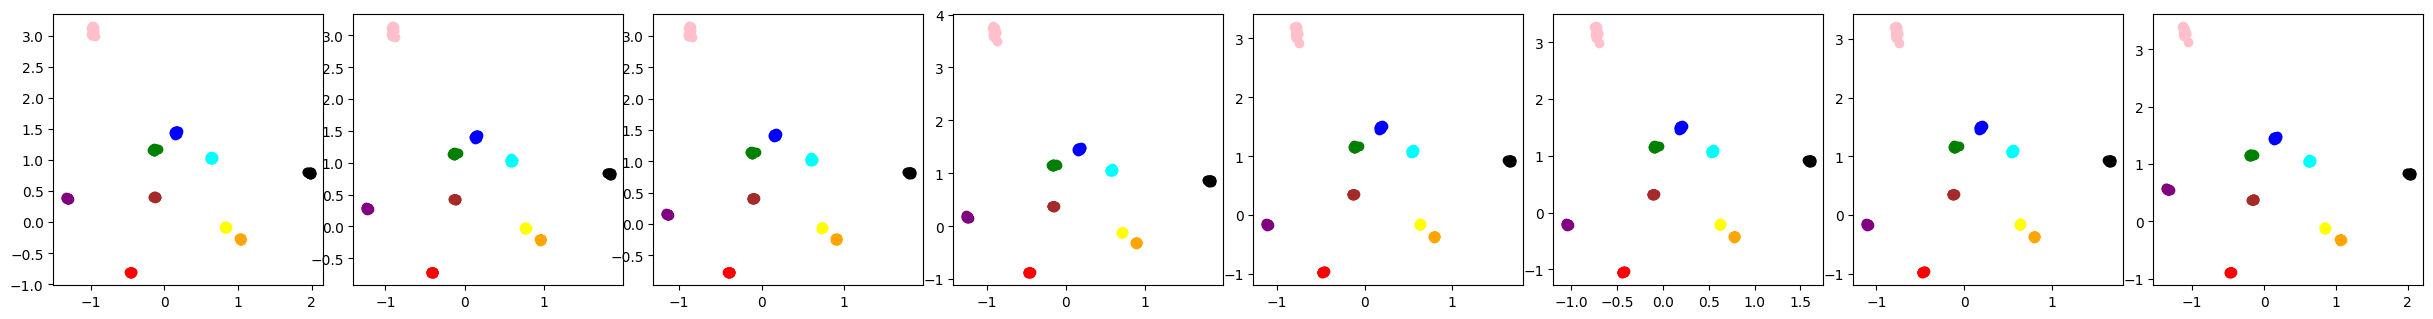

In [11]:
c = ['b', 'r', 'orange', 'yellow','cyan', 'purple', 'green', 'black', 'pink', 'brown']

fig, axes = plt.subplots(1, model_rec.n_obs, figsize=(model_rec.n_obs*3, 3))
torch.manual_seed(88)
for i in range(model_rec.n_obs):
    for j in range(len(c)):
        axes[i].scatter(z_seq[n_samples*j:n_samples*(j+1), i, 0].cpu(), z_seq[n_samples*j:n_samples*(j+1), i, 1].cpu(), c=c[j])
plt.tight_layout(pad=0)
#plt.savefig('plots/latent_2D_flow_shaping.png', bbox_inches="tight")

In [ ]:
model_rec.n

In [ ]:
lim = 8
im_size = 28

torch.manual_seed(8)
idx = torch.randperm(len(eval_data))

# Train recon
fig, axes = plt.subplots(8, lim, figsize=(lim, 4))
torch.manual_seed(88)
for k in range(lim):
    i, t = 0, k
    axes[0][k].imshow(eval_data[idx][i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[0][k].axis('off')
    axes[1][k].imshow(recon[idx][i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[1][k].axis('off')
    i, t = 1, k
    axes[2][k].imshow(eval_data[idx][i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[2][k].axis('off')
    axes[3][k].imshow(recon[idx][i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[3][k].axis('off')
    i, t = 2, k
    axes[4][k].imshow(eval_data[idx][i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[4][k].axis('off')
    axes[5][k].imshow(recon[idx][i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[5][k].axis('off')
    i, t = 3, k
    axes[6][k].imshow(eval_data[idx][i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[6][k].axis('off')
    axes[7][k].imshow(recon[idx][i, t].reshape(im_size, im_size).cpu(), cmap='gray')
    axes[7][k].axis('off')

In [24]:
import torch

test_data = torch.load(os.path.join('/gpfswork/rech/wlr/uhw48em/rvae/data/sprites/Sprites_test.pt'), map_location="cpu")['data']



In [26]:
torch.save(test_data, '/gpfswork/rech/wlr/uhw48em/rvae/data/sprites/Sprites_test_only_data.pt')

In [1]:
import torch
from pythae.models import AutoModel
import matplotlib.pyplot as plt
import numpy as np

In [2]:
model = AutoModel.load_from_folder('/home/clement/Documents/rvae/benchmark_VAE/examples/notebooks/models_training/from_jz/VAE_IAF_training_2022-11-08_22-34-02/final_model')
model.cuda()

LVAE_IAF(
  (decoder): Decoder_Chairs(
    (fc): Linear(in_features=16, out_features=2048, bias=True)
    (layers): Sequential(
      (0): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ResBlock(
        (conv_block): Sequential(
          (0): ReLU()
          (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): ReLU()
          (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
        )
      )
      (2): ResBlock(
        (conv_block): Sequential(
          (0): ReLU()
          (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): ReLU()
          (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
        )
      )
      (3): ResBlock(
        (conv_block): Sequential(
          (0): ReLU()
          (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): ReLU()
          (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
       

In [3]:
z = torch.randn(1000, model.latent_dim).cuda()
gen = torch.clamp(model.generate(z).detach(), 0, 1)

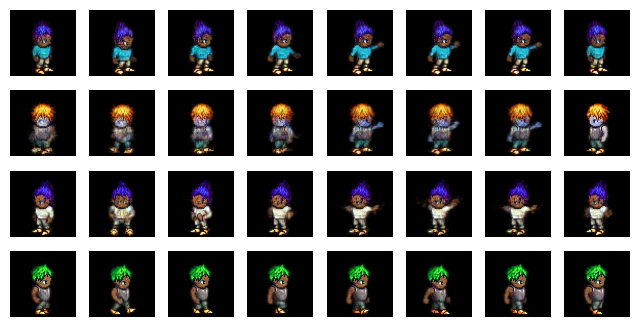

In [4]:
lim = model.n_obs
im_size = 28

torch.manual_seed(8)
idx = torch.randperm(len(gen))

# Train recon
fig, axes = plt.subplots(4, lim, figsize=(lim, 4))
torch.manual_seed(88)
for k in range(lim):
    i, t = 0, k
    axes[0][k].imshow(np.moveaxis(gen[i, k].cpu().numpy(), 0, 2), cmap='gray')
    axes[0][k].axis('off')
    i, t = 1, k
    axes[1][k].imshow(np.moveaxis(gen[i, k].cpu().numpy(), 0, 2), cmap='gray')
    axes[1][k].axis('off')
    i, t = 2, k
    axes[2][k].imshow(np.moveaxis(gen[i, k].cpu().numpy(), 0, 2), cmap='gray')
    axes[2][k].axis('off')
    i, t = 3, k
    axes[3][k].imshow(np.moveaxis(gen[i, k].cpu().numpy(), 0, 2), cmap='gray')
    axes[3][k].axis('off')

In [5]:
from pytorch_fid.fid_score import calculate_fid_given_arrays
%load_ext autoreload
%autoreload 2

test_data = torch.load(os.path.join('/gpfswork/rech/wlr/uhw48em/rvae/data/sprites/Sprites_test.pt'), map_location="cpu")['data']

/home/clement/anaconda3/envs/rhmc/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/clement/anaconda3/envs/rhmc/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIlEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  warn(f"Failed to load image Python extension: {e}")


In [6]:
gen = (255. * gen).type(torch.uint8)
test_data = (255. * test_data).type(torch.uint8)

In [7]:
calculate_fid_given_arrays(np.moveaxis(gen.cpu().numpy().reshape(-1, 3, 64, 64), 1, 3) / 255., np.moveaxis(test_data.cpu().numpy().reshape(-1, 3, 64, 64), 1, 3) / 255., batch_size=50, device='cuda:0', dims=2048)

/home/clement/anaconda3/envs/rhmc/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/clement/anaconda3/envs/rhmc/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
100%|██████████| 427/427 [00:28<00:00, 14.73it/s]


50.91142997964661

In [8]:
from imageio import imwrite

def save_img(img_tensor: torch.Tensor, dir_path: str, img_name: str):
        """Saves a data point as .png file in dir_path with img_name as name.

        Args:
            img_tensor (torch.Tensor): The image of shape CxHxW in the range [0-1]
            dir_path (str): The folder where in which the images must be saved
            ig_name (str): The name to apply to the file containing the image.
        """

        if not os.path.exists(dir_path):
            os.makedirs(dir_path)
            print(f"--> Created folder {dir_path}. Images will be saved here")

        img = 255.0 * torch.movedim(img_tensor, 0, 2).cpu().detach().numpy()
        if img.shape[-1] == 1:
            img = np.repeat(img, repeats=3, axis=-1)

        img = img.astype("uint8")
        imwrite(os.path.join(dir_path, f"{img_name}"), img)

In [9]:
gen_imgs = gen.reshape(-1, 3, 64, 64).float() / 255.
for i in range(len(gen_imgs)):
    save_img(gen_imgs[i], "generation", "%08d.png" % i)

In [10]:
test_imgs = test_data.reshape(-1, 3, 64, 64).float() / 255.
for i in range(len(test_imgs)):
    save_img(test_imgs[i], "test_img", "%08d.png" % i)

In [20]:
gen.shape, test_data.shape

(torch.Size([10, 8, 3, 64, 64]), torch.Size([2664, 8, 3, 64, 64]))

In [21]:
10000 / 8

1250.0